# EOSC 454/556B Assignment 2: Question 4
## Noise Effects on Inversion

In this question, we explore how noise in the data affects the recovered interval velocity.

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy.interpolate import CubicSpline

# Set random seed for reproducibility
np.random.seed(42)

# Set plotting parameters
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

## Setup: Reuse functions from previous questions

In [4]:
def compute_interval_velocity(t, v0, alpha, beta, omega):
    """
    Compute interval velocity as a function of time.
    """
    v_int = v0 + alpha * np.sin(omega * t) + beta * t
    return v_int


def compute_rms_velocity(t, v0, alpha, beta, omega):
    """
    Compute RMS velocity numerically.
    """
    V_rms = np.zeros_like(t)
    
    for i, t_val in enumerate(t):
        if t_val == 0:
            V_rms[i] = v0
        else:
            u = np.linspace(0, t_val, 500)
            v_int_u = compute_interval_velocity(u, v0, alpha, beta, omega)
            integral = integrate.simpson(v_int_u**2, x=u)
            V_rms[i] = np.sqrt(integral / t_val)
    
    return V_rms


def estimate_interval_from_rms(t, V_rms):
    """
    Estimate interval velocity from RMS velocity using finite differences.
    """
    v_int_est = np.zeros_like(V_rms)
    dV_dt = np.zeros_like(V_rms)
    
    # Forward difference for first point
    dV_dt[0] = (V_rms[1] - V_rms[0]) / (t[1] - t[0])
    
    # Central difference for interior points
    for i in range(1, len(t) - 1):
        dV_dt[i] = (V_rms[i+1] - V_rms[i-1]) / (t[i+1] - t[i-1])
    
    # Backward difference for last point
    dV_dt[-1] = (V_rms[-1] - V_rms[-2]) / (t[-1] - t[-2])
    
    # Compute interval velocity
    for i, t_val in enumerate(t):
        if t_val == 0:
            v_int_est[i] = V_rms[i]
        else:
            bracket_term = 1 + (2 * t_val * dV_dt[i]) / V_rms[i]
            if bracket_term < 0:
                bracket_term = 0
            v_int_est[i] = V_rms[i] * np.sqrt(bracket_term)
    
    return v_int_est

In [5]:
# Define parameters (same as Q2)
v0 = 2000  # m/s
alpha = 50  # m/s
beta = 20  # m/s²
f = 1  # Hz
omega = 2 * np.pi * f  # rad/s

# Create fine time grid
n_points = 200
t_fine = np.linspace(0, 2, n_points)

# Compute true interval and RMS velocities
v_int_true = compute_interval_velocity(t_fine, v0, alpha, beta, omega)
V_rms_true = compute_rms_velocity(t_fine, v0, alpha, beta, omega)

## Question 4(a): Gaussian Noise at Different Levels

Based on Q3(d), we found that cubic spline interpolation with moderate decimation (n=10) gave reasonable results. We'll use this as our starting point.

In [6]:
# Choose decimation level based on Q3 results
n_dec = 10  # Moderate decimation - worked reasonably well with cubic spline

# Downsample
t_coarse = t_fine[::n_dec]
V_rms_coarse = V_rms_true[::n_dec]

print(f"Using decimation level n={n_dec}")
print(f"Number of data points: {len(t_coarse)}")

Using decimation level n=10
Number of data points: 20


In [7]:
# Define noise levels (standard deviations)
noise_levels = [0.5, 1.0, 1.5]  # m/s

# Store results
results_noise = {}

for sigma in noise_levels:
    # Add Gaussian noise to downsampled RMS data
    noise = np.random.normal(0, sigma, len(V_rms_coarse))
    V_rms_noisy = V_rms_coarse + noise
    
    # Cubic spline interpolation
    spline = CubicSpline(t_coarse, V_rms_noisy)
    V_rms_interp = spline(t_fine)
    
    # Recover interval velocity
    v_int_recovered = estimate_interval_from_rms(t_fine, V_rms_interp)
    
    # Store results
    results_noise[sigma] = {
        'V_rms_noisy': V_rms_noisy,
        'V_rms_interp': V_rms_interp,
        'v_int_recovered': v_int_recovered,
        'noise': noise
    }
    
    print(f"\nNoise level σ = {sigma} m/s:")
    print(f"  Actual noise range: [{noise.min():.3f}, {noise.max():.3f}] m/s")


Noise level σ = 0.5 m/s:
  Actual noise range: [-0.957, 0.790] m/s

Noise level σ = 1.0 m/s:
  Actual noise range: [-1.960, 1.852] m/s

Noise level σ = 1.5 m/s:
  Actual noise range: [-2.645, 1.586] m/s


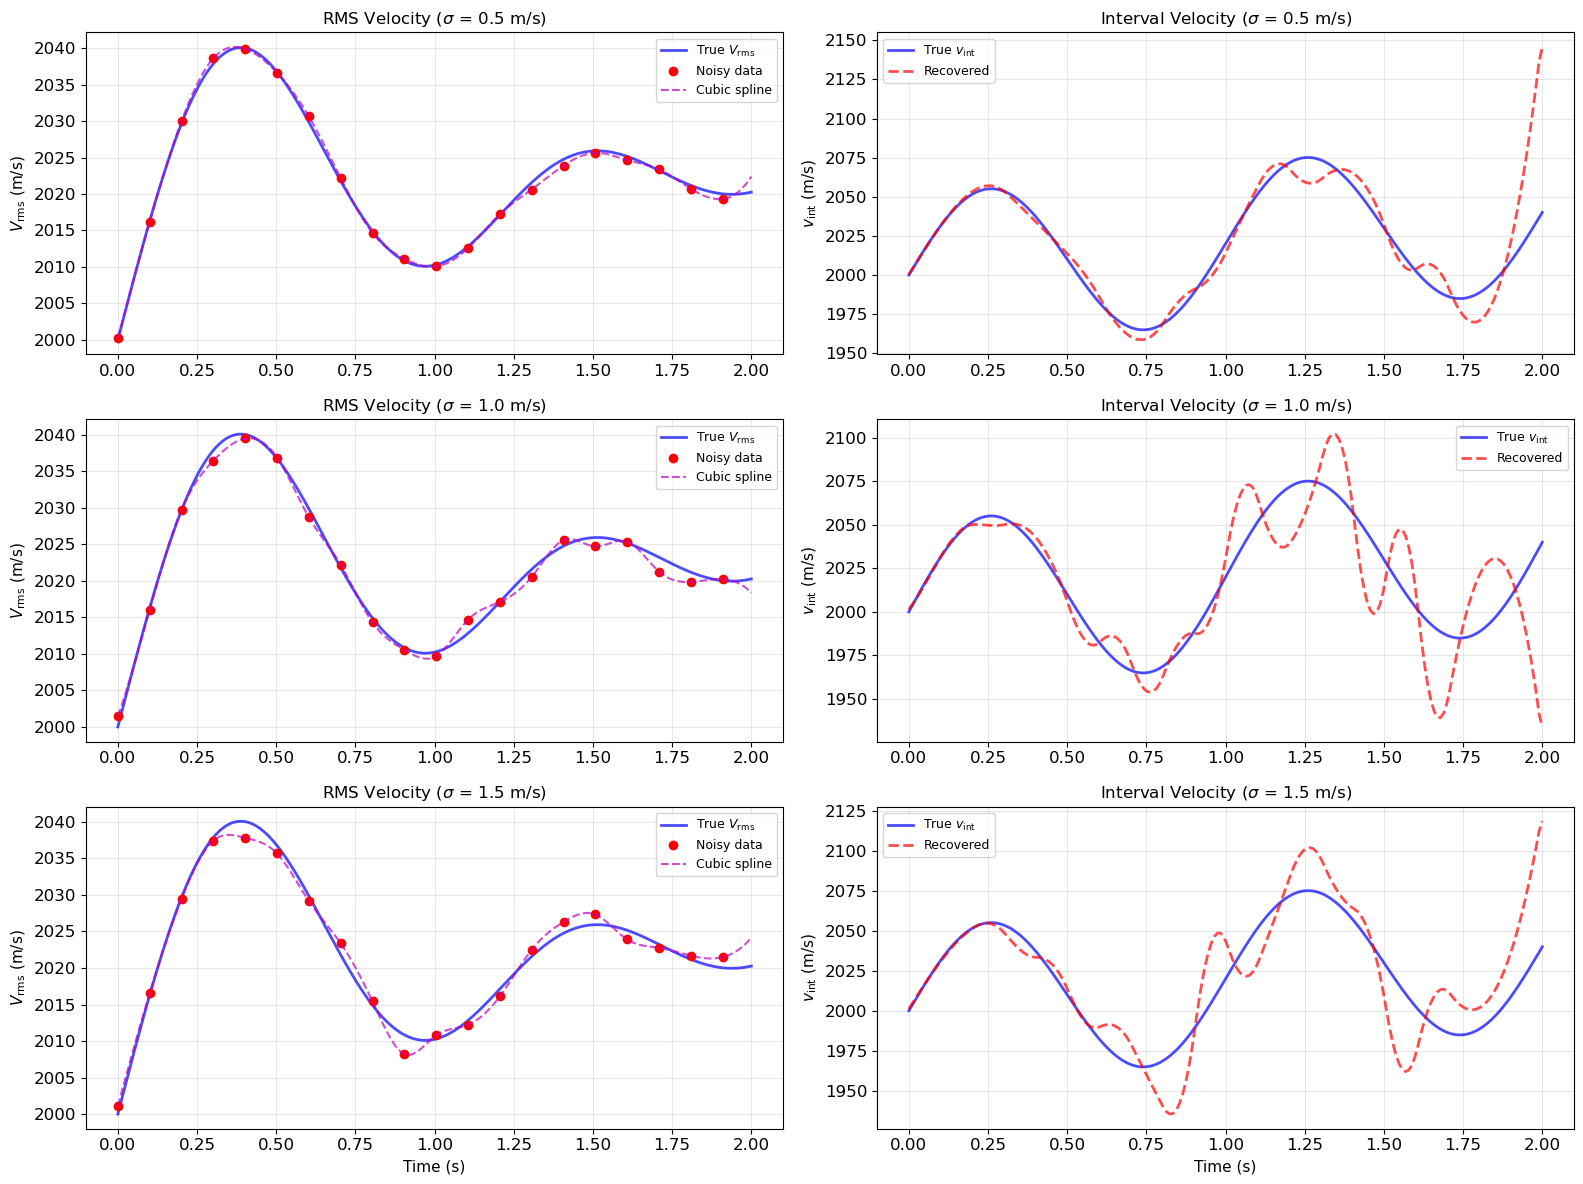

In [8]:
# Create comprehensive plot for different noise levels
fig = plt.figure(figsize=(16, 12))

for idx, sigma in enumerate(noise_levels):
    # RMS velocity plots (left column)
    ax = plt.subplot(3, 2, 2*idx + 1)
    ax.plot(t_fine, V_rms_true, 'b-', linewidth=2, label='True $V_{\\text{rms}}$', alpha=0.7)
    ax.plot(t_coarse, results_noise[sigma]['V_rms_noisy'], 'ro', 
            markersize=6, label='Noisy data')
    ax.plot(t_fine, results_noise[sigma]['V_rms_interp'], 'm--', 
            linewidth=1.5, label='Cubic spline', alpha=0.7)
    ax.set_ylabel('$V_{\\text{rms}}$ (m/s)', fontsize=11)
    ax.set_title(f'RMS Velocity ($\\sigma$ = {sigma} m/s)', fontsize=12)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    if idx == 2:
        ax.set_xlabel('Time (s)', fontsize=11)
    
    # Interval velocity plots (right column)
    ax = plt.subplot(3, 2, 2*idx + 2)
    ax.plot(t_fine, v_int_true, 'b-', linewidth=2, label='True $v_{\\text{int}}$', alpha=0.7)
    ax.plot(t_fine, results_noise[sigma]['v_int_recovered'], 'r--', 
            linewidth=2, label='Recovered', alpha=0.7)
    ax.set_ylabel('$v_{\\text{int}}$ (m/s)', fontsize=11)
    ax.set_title(f'Interval Velocity ($\\sigma$ = {sigma} m/s)', fontsize=12)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    if idx == 2:
        ax.set_xlabel('Time (s)', fontsize=11)

plt.tight_layout()
plt.savefig('q4a_noise_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [9]:
# Analyze errors
print("\n" + "="*70)
print("ERROR ANALYSIS FOR DIFFERENT NOISE LEVELS")
print("="*70)

for sigma in noise_levels:
    error = np.abs(v_int_true - results_noise[sigma]['v_int_recovered'])
    
    print(f"\nNoise level σ = {sigma} m/s:")
    print(f"  Max error:  {error.max():.4f} m/s")
    print(f"  Mean error: {error.mean():.4f} m/s")
    print(f"  Std error:  {error.std():.4f} m/s")


ERROR ANALYSIS FOR DIFFERENT NOISE LEVELS

Noise level σ = 0.5 m/s:
  Max error:  105.7528 m/s
  Mean error: 7.9673 m/s
  Std error:  14.4018 m/s

Noise level σ = 1.0 m/s:
  Max error:  106.1224 m/s
  Mean error: 15.8096 m/s
  Std error:  16.7684 m/s

Noise level σ = 1.5 m/s:
  Max error:  78.4628 m/s
  Mean error: 15.6261 m/s
  Std error:  15.1343 m/s


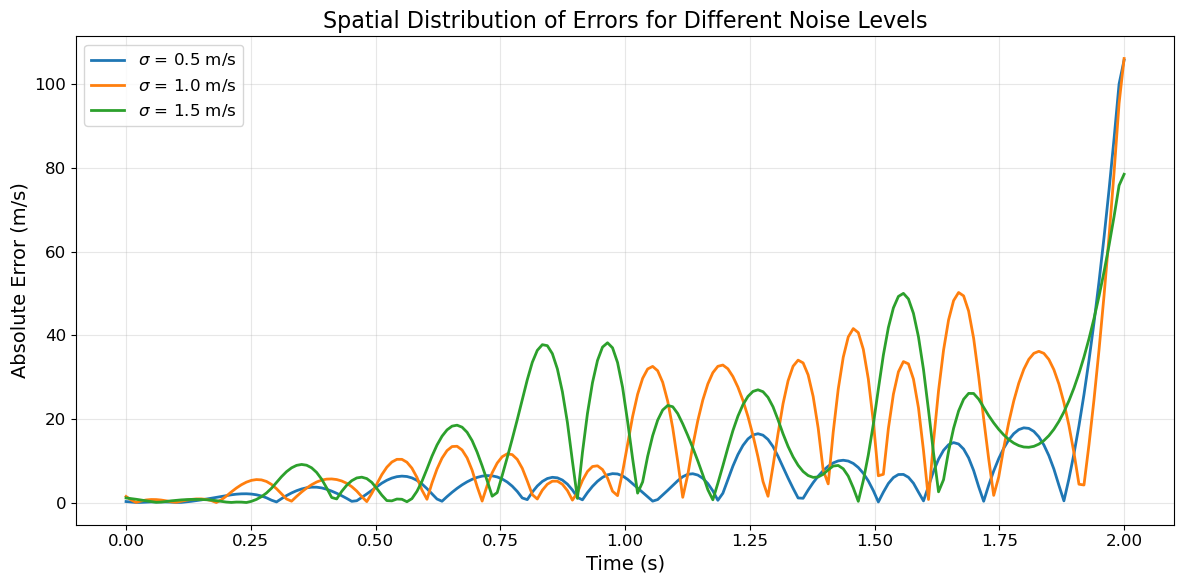

In [10]:
# Plot error distribution along time
plt.figure(figsize=(12, 6))

for sigma in noise_levels:
    error = np.abs(v_int_true - results_noise[sigma]['v_int_recovered'])
    plt.plot(t_fine, error, linewidth=2, label=f'$\\sigma$ = {sigma} m/s')

plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('Absolute Error (m/s)', fontsize=14)
plt.title('Spatial Distribution of Errors for Different Noise Levels', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('q4a_error_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

### Discussion for Q4(a)

**How the recovered model changes with noise level:**

As noise increases, the recovered interval velocity shows increasing deviations from the true model. The noise in the RMS velocity data gets amplified through the derivative operation in the inversion formula, leading to oscillations and artifacts in the recovered interval velocity.

**Regions most/least affected:**

The errors are generally larger at later times (larger t values). This is because:
1. The derivative term in the inversion formula is multiplied by t: $\frac{2tV'_{rms}(t)}{V_{rms}(t)}$
2. Noise in $V_{rms}$ creates noise in its derivative $V'_{rms}$, which gets amplified by the factor of t
3. Regions where the true velocity changes rapidly (high curvature) are also more sensitive to noise

**Why this happens:**

The inversion process involves taking derivatives, which is an ill-posed operation that amplifies high-frequency noise. Even small perturbations in the data can lead to large errors in the derivative, especially when multiplied by increasing time values.

## Question 4(b): Simplified Model with Different Noise Types

Now we set $\alpha = 0$, giving us a simpler linear model:
$$v_{\text{int}} = v_0 + \beta t$$

In [11]:
# Simplified model parameters
alpha_simple = 0  # Remove sinusoidal component
beta_simple = 20  # Keep linear trend

# Compute simplified true velocities
v_int_simple = compute_interval_velocity(t_fine, v0, alpha_simple, beta_simple, omega)
V_rms_simple = compute_rms_velocity(t_fine, v0, alpha_simple, beta_simple, omega)

# Downsample
V_rms_simple_coarse = V_rms_simple[::n_dec]

print("Simplified model: v_int = v0 + β*t")
print(f"This is a purely linear velocity model with constant acceleration.")

Simplified model: v_int = v0 + β*t
This is a purely linear velocity model with constant acceleration.


### Part (b.1): Gaussian Noise on Simplified Model

In [12]:
# Test with different Gaussian noise levels
noise_levels_simple = [0.5, 1.0, 2.0]  # m/s

results_simple_gaussian = {}

for sigma in noise_levels_simple:
    # Add Gaussian noise
    noise = np.random.normal(0, sigma, len(V_rms_simple_coarse))
    V_rms_noisy = V_rms_simple_coarse + noise
    
    # Cubic spline interpolation
    spline = CubicSpline(t_coarse, V_rms_noisy)
    V_rms_interp = spline(t_fine)
    
    # Recover interval velocity
    v_int_recovered = estimate_interval_from_rms(t_fine, V_rms_interp)
    
    results_simple_gaussian[sigma] = {
        'V_rms_noisy': V_rms_noisy,
        'V_rms_interp': V_rms_interp,
        'v_int_recovered': v_int_recovered
    }

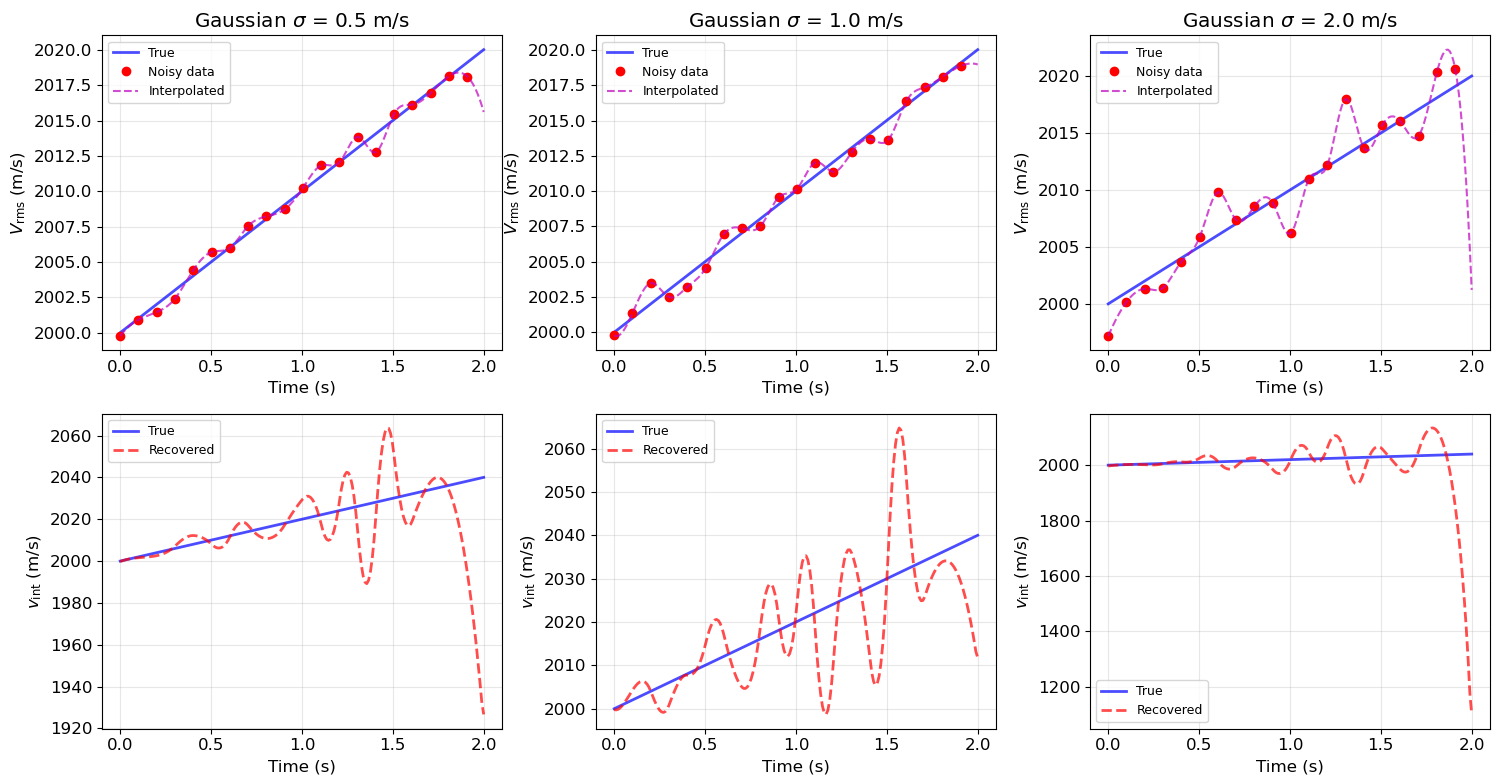

In [13]:
# Plot Gaussian noise results for simplified model
fig, axes = plt.subplots(2, len(noise_levels_simple), figsize=(15, 8))

for idx, sigma in enumerate(noise_levels_simple):
    # RMS velocity
    ax = axes[0, idx]
    ax.plot(t_fine, V_rms_simple, 'b-', linewidth=2, label='True', alpha=0.7)
    ax.plot(t_coarse, results_simple_gaussian[sigma]['V_rms_noisy'], 'ro', 
            markersize=6, label='Noisy data')
    ax.plot(t_fine, results_simple_gaussian[sigma]['V_rms_interp'], 'm--', 
            linewidth=1.5, label='Interpolated', alpha=0.7)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('$V_{\\text{rms}}$ (m/s)')
    ax.set_title(f'Gaussian $\\sigma$ = {sigma} m/s')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    
    # Interval velocity
    ax = axes[1, idx]
    ax.plot(t_fine, v_int_simple, 'b-', linewidth=2, label='True', alpha=0.7)
    ax.plot(t_fine, results_simple_gaussian[sigma]['v_int_recovered'], 'r--', 
            linewidth=2, label='Recovered', alpha=0.7)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('$v_{\\text{int}}$ (m/s)')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('q4b_gaussian_simplified.png', dpi=300, bbox_inches='tight')
plt.show()

### Part (b.2): Correlated Noise on Simplified Model

Now we add correlated noise of the form $\cos(\omega t)$.

In [14]:
# Test with different amplitudes of correlated noise
corr_noise_amplitudes = [0.5, 1.0, 2.0]  # m/s

results_simple_correlated = {}

for amp in corr_noise_amplitudes:
    # Add correlated noise: cos(omega*t)
    corr_noise = amp * np.cos(omega * t_coarse)
    V_rms_noisy = V_rms_simple_coarse + corr_noise
    
    # Cubic spline interpolation
    spline = CubicSpline(t_coarse, V_rms_noisy)
    V_rms_interp = spline(t_fine)
    
    # Recover interval velocity
    v_int_recovered = estimate_interval_from_rms(t_fine, V_rms_interp)
    
    results_simple_correlated[amp] = {
        'V_rms_noisy': V_rms_noisy,
        'V_rms_interp': V_rms_interp,
        'v_int_recovered': v_int_recovered,
        'corr_noise': corr_noise
    }

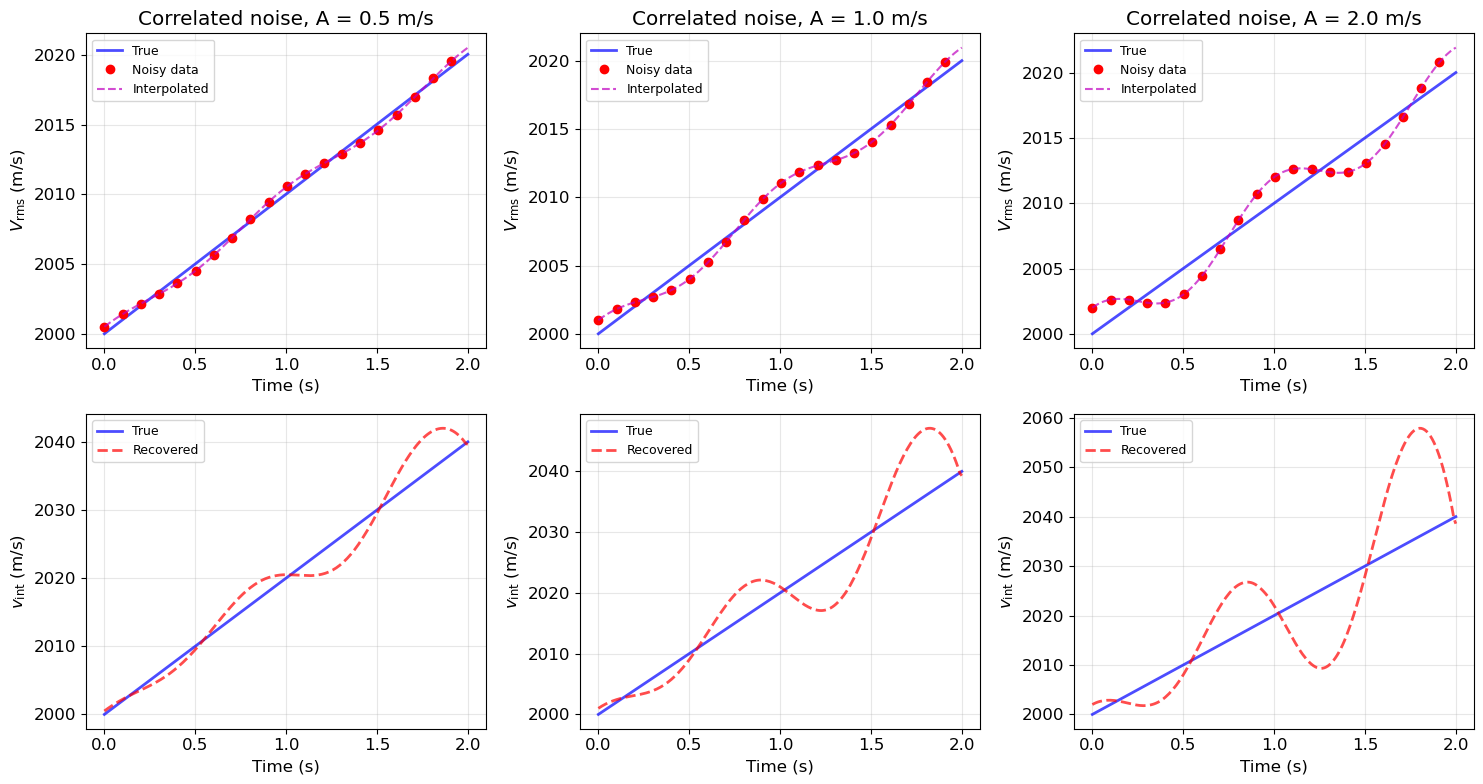

In [15]:
# Plot correlated noise results
fig, axes = plt.subplots(2, len(corr_noise_amplitudes), figsize=(15, 8))

for idx, amp in enumerate(corr_noise_amplitudes):
    # RMS velocity
    ax = axes[0, idx]
    ax.plot(t_fine, V_rms_simple, 'b-', linewidth=2, label='True', alpha=0.7)
    ax.plot(t_coarse, results_simple_correlated[amp]['V_rms_noisy'], 'ro', 
            markersize=6, label='Noisy data')
    ax.plot(t_fine, results_simple_correlated[amp]['V_rms_interp'], 'm--', 
            linewidth=1.5, label='Interpolated', alpha=0.7)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('$V_{\\text{rms}}$ (m/s)')
    ax.set_title(f'Correlated noise, A = {amp} m/s')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    
    # Interval velocity
    ax = axes[1, idx]
    ax.plot(t_fine, v_int_simple, 'b-', linewidth=2, label='True', alpha=0.7)
    ax.plot(t_fine, results_simple_correlated[amp]['v_int_recovered'], 'r--', 
            linewidth=2, label='Recovered', alpha=0.7)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('$v_{\\text{int}}$ (m/s)')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('q4b_correlated_noise.png', dpi=300, bbox_inches='tight')
plt.show()

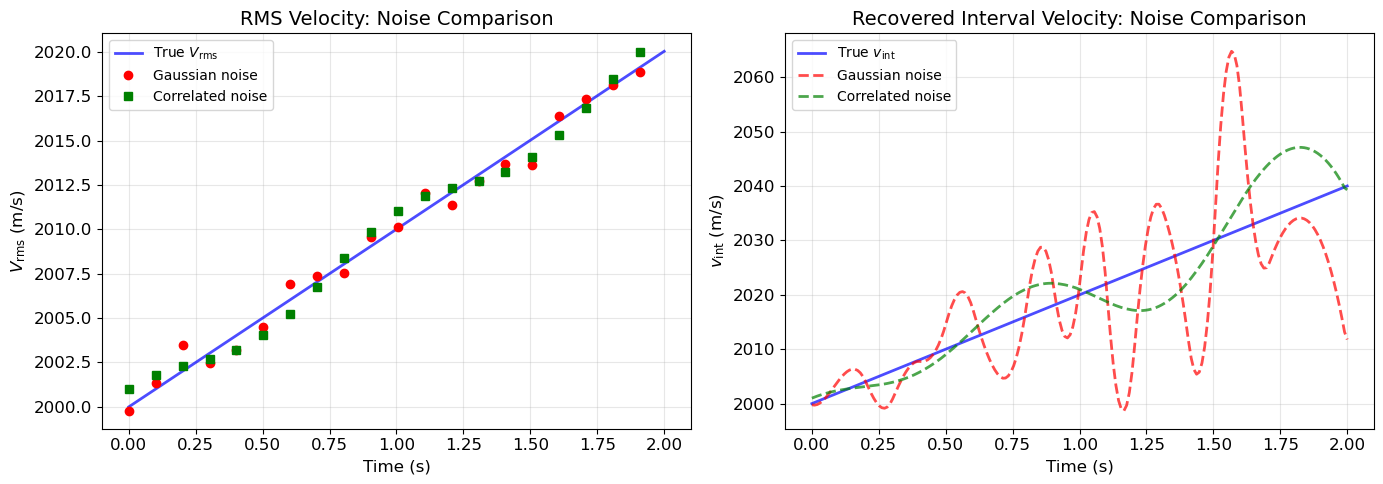

In [16]:
# Direct comparison: Gaussian vs Correlated noise
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Choose amplitude of 1.0 m/s for comparison
amp_compare = 1.0

# RMS velocity comparison
ax = axes[0]
ax.plot(t_fine, V_rms_simple, 'b-', linewidth=2, label='True $V_{\\text{rms}}$', alpha=0.7)
ax.plot(t_coarse, results_simple_gaussian[amp_compare]['V_rms_noisy'], 'ro', 
        markersize=6, label='Gaussian noise')
ax.plot(t_coarse, results_simple_correlated[amp_compare]['V_rms_noisy'], 'gs', 
        markersize=6, label='Correlated noise')
ax.set_xlabel('Time (s)', fontsize=12)
ax.set_ylabel('$V_{\\text{rms}}$ (m/s)', fontsize=12)
ax.set_title('RMS Velocity: Noise Comparison', fontsize=14)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Interval velocity comparison
ax = axes[1]
ax.plot(t_fine, v_int_simple, 'b-', linewidth=2, label='True $v_{\\text{int}}$', alpha=0.7)
ax.plot(t_fine, results_simple_gaussian[amp_compare]['v_int_recovered'], 'r--', 
        linewidth=2, label='Gaussian noise', alpha=0.7)
ax.plot(t_fine, results_simple_correlated[amp_compare]['v_int_recovered'], 'g--', 
        linewidth=2, label='Correlated noise', alpha=0.7)
ax.set_xlabel('Time (s)', fontsize=12)
ax.set_ylabel('$v_{\\text{int}}$ (m/s)', fontsize=12)
ax.set_title('Recovered Interval Velocity: Noise Comparison', fontsize=14)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('q4b_noise_type_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [17]:
# Error analysis
print("\n" + "="*70)
print("SIMPLIFIED MODEL - NOISE COMPARISON")
print("="*70)

print("\nGaussian Noise:")
for sigma in noise_levels_simple:
    error = np.abs(v_int_simple - results_simple_gaussian[sigma]['v_int_recovered'])
    print(f"  σ = {sigma} m/s: Max error = {error.max():.4f} m/s, Mean error = {error.mean():.4f} m/s")

print("\nCorrelated Noise (cos(ωt)):")
for amp in corr_noise_amplitudes:
    error = np.abs(v_int_simple - results_simple_correlated[amp]['v_int_recovered'])
    print(f"  A = {amp} m/s: Max error = {error.max():.4f} m/s, Mean error = {error.mean():.4f} m/s")


SIMPLIFIED MODEL - NOISE COMPARISON

Gaussian Noise:
  σ = 0.5 m/s: Max error = 113.2737 m/s, Mean error = 11.0130 m/s
  σ = 1.0 m/s: Max error = 33.3970 m/s, Mean error = 8.1183 m/s
  σ = 2.0 m/s: Max error = 939.9202 m/s, Mean error = 51.6479 m/s

Correlated Noise (cos(ωt)):
  A = 0.5 m/s: Max error = 5.5336 m/s, Mean error = 2.0235 m/s
  A = 1.0 m/s: Max error = 11.0527 m/s, Mean error = 4.0459 m/s
  A = 2.0 m/s: Max error = 22.0480 m/s, Mean error = 8.0873 m/s


### Discussion for Q4(b)

**Simplified model with Gaussian noise:**

For the linear model ($v_{\text{int}} = v_0 + \beta t$), Gaussian noise still introduces errors in the recovered velocity. However, the effects are somewhat more predictable than with the complex model because there's no sinusoidal component to interact with the noise.

**What happens with correlated noise:**

Correlated noise of the form $\cos(\omega t)$ has a very different effect:

1. **Systematic bias**: Unlike random Gaussian noise, correlated noise introduces systematic oscillations in the recovered interval velocity.

2. **Smooth interpolation**: The cubic spline interpolation effectively captures the correlated noise pattern, which then propagates through the inversion in a predictable way.

3. **Interference patterns**: The correlated noise creates a pseudo-periodic structure in the recovered interval velocity, even though the true model is purely linear.

4. **Error magnitude**: Correlated noise can sometimes produce larger systematic errors than Gaussian noise of the same amplitude because the noise pattern aligns coherently across multiple data points.

**Key insight**: The type of noise matters significantly. Random noise tends to average out to some degree through the smoothing provided by interpolation, whereas correlated noise introduces systematic biases that can be harder to identify and remove. This has important implications for real seismic data, where noise is rarely purely random and often contains coherent signals from various sources.

## Summary for Question 4

Key findings:

1. **Noise amplification**: The inversion process amplifies noise through derivative operations, with effects increasing at later times due to the factor of $t$ in the inversion formula.

2. **Spatial sensitivity**: Errors are not uniform—they're larger where $t$ is large and where the true velocity varies rapidly.

3. **Model complexity**: The simplified linear model is somewhat more robust to noise than the complex model with oscillations.

4. **Noise type matters**: Correlated noise introduces systematic biases that can be more problematic than random Gaussian noise of the same magnitude.

5. **Practical implications**: In real applications, careful data quality control and noise characterization are essential before attempting velocity inversions.